In [1]:
import matplotlib.pyplot as plt

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, linewidth=0.5, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from math import sqrt

def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim=1, unbiased=False, keepdim=True).sqrt()
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

## 컨볼루션 임베딩
class Embedding(nn.Module):
    def __init__(self, embed_dim, kernel_size, stride, padding, dropout=0.0):
        super(Embedding, self).__init__()
        self.embedding = nn.Conv2d(1, 
                                   embed_dim, 
                                   kernel_size=kernel_size, 
                                   stride=stride, 
                                   padding=padding)
        
    def forward(self, x):
        return self.embedding(x)

## 인코더
class MultiheadAttention(nn.Module):
    def __init__(self, *, dim=124, num_heads=4, dropout=0.1) -> None:
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        
    
    def forward(self, x):
        x = self.norm(x)
        x, _ = self.attn(x, x, x)
        return x

    
class FeedForwardNetwork(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

    
class Encoder(nn.Module):
    def __init__(self, dim=124, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                MultiheadAttention(dim=dim, num_heads=num_heads, dropout=dropout),
                FeedForwardNetwork(dim=dim, hidden_dim=dim * 4, dropout=dropout)
            ]) for _ in range(num_layers)
        ])

    def forward(self, x):
        height = x.shape[2]
        x = rearrange(x, 'b c h w -> b (h w) c')

        for attn, mlp in self.layers:
            x = attn(x) + x
            x = mlp(x) + x

        x = rearrange(x, 'b (h w) c -> b c h w', h=height)
        return x

    
class Head(nn.Module):
    def __init__(self, input_dim = 256 ,dim=128, num_classes=11):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(input_dim , dim, kernel_size=1),  
            nn.Conv2d(dim, num_classes, kernel_size=1)
        )
        
    def forward(self, x):
        return self.layers(x)
## 디코더
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class Decoder(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(Decoder, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ARC_Net(nn.Module):
    def __init__(
        self, 
        *,
        dim=128,
        num_heads=4,
        num_layers=4,
        num_classes=11,
        dropout=0.1,
        kernel_stride_padding=((1, 1, 0), (3, 1, 1))
    ) -> None:
        super().__init__()
        self.stages = nn.ModuleList()

        # 각 커널 크기, 스트라이드, 패딩을 튜플로 묶어서 처리
        for (kernel_size, stride, padding) in kernel_stride_padding:
            self.stages.append(
                nn.ModuleList([
                    Embedding(embed_dim=dim, kernel_size=kernel_size, stride=stride, padding=padding, dropout=dropout),
                    Encoder(dim=dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout)
                ])
            )
        
        # Decoder를 통해 attention을 적용하여 결합
        self.decoder = Decoder(gate_channels = dim * len(kernel_stride_padding))  
        self.head = Head(input_dim=dim * len(kernel_stride_padding), dim=dim, num_classes=num_classes)

    def forward(self, x):
        all_outputs = []

        # 각 커널 크기, 스트라이드, 패딩에 대해 독립적으로 처리
        for embedding, encoder in self.stages:
            scale_x = embedding(x)
            scale_x = encoder(scale_x)
            all_outputs.append(scale_x)

        # 다양한 커널 크기에서 추출된 특징을 병합
        x = torch.cat(all_outputs, dim=1)
        
        # Decoder를 통해 어텐션 적용 및 결과와 결합
        x = self.decoder(x)
        # print("ch_sp:",x.shape)
        
        # 병합된 특징을 헤드에 전달
        x = self.head(x)
        return x

In [4]:
# 모델 생성 및 출력
model_args = {
        'dim': 32,
        'num_heads': 4,
        'num_layers': 4,
        'num_classes': 11,
        'dropout': 0.1,
        'kernel_stride_padding': ((1, 1, 0),(5, 1, 2))
    }

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ARC_Net(**model_args).to(device)
# 입력 텐서 생성
x = torch.randn(10, 1, 30, 30).to(device)

print(model(x).shape)

torch.Size([10, 11, 30, 30])


In [6]:
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outer_model = ARC_Net(**model_args).to(device)

# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(outer_model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")
from torchinfo import summary

summary(outer_model, input_size=(1, 1, 30, 30))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
FLOPs: 62.906M
파라미터 수: 71.347K


Layer (type:depth-idx)                                       Output Shape              Param #
ARC_Net                                                      [1, 11, 30, 30]           --
├─ModuleList: 1-1                                            --                        --
│    └─ModuleList: 2-1                                       --                        --
│    │    └─Embedding: 3-1                                   [1, 32, 30, 30]           64
│    │    └─Encoder: 3-2                                     [1, 32, 30, 30]           50,560
│    └─ModuleList: 2-2                                       --                        --
│    │    └─Embedding: 3-3                                   [1, 32, 30, 30]           832
│    │    └─Encoder: 3-4                                     [1, 32, 30, 30]           50,560
├─Decoder: 1-2                                               [1, 64, 30, 30]           --
│    └─ChannelGate: 2-3                                      [1, 64, 30, 30]          

In [7]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [8]:
import torch
#weight = torch.ones(11).to('cuda')
#weight[0] = 0.0005  # 0은 무시
#print(weight)

Train Loop
N개의 샘플 배치를 불러온다.
1. 각 샘플에 대해 이너 모델을 아우터 모델에서 복사해 로스를 계산한다.
2. 이너 모델의 파라미터를 업데이트한다.
3. 업데이트 된 이너 모델을 바탕으로 테스크 셋에 대한 로스를 계산한다.
4. 테스크 셋에 대한 로스를 저장한다.
5. 모든 테스크 셋에 대해 로스가 구해지면 아우터 모델의 파라미터를 업데이트한다.

Using cuda device
Epoch 1/500


Validation:  89%|████████▉ | 8/9 [04:44<00:33, 33.86s/it]

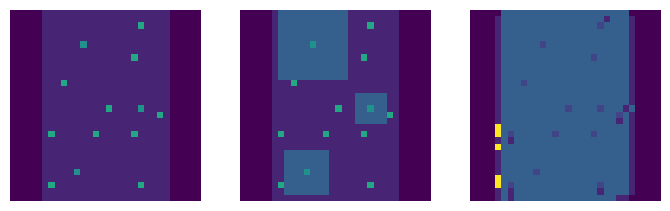

Validation: 100%|██████████| 9/9 [04:58<00:00, 33.12s/it]


Epoch 1/500, Loss: 1.8457640421561239, Accuracy: 50.20047708470791%
Epoch 2/500


Validation:  89%|████████▉ | 8/9 [05:05<00:37, 37.51s/it]

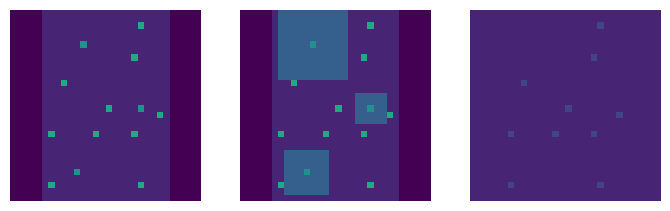

Validation: 100%|██████████| 9/9 [05:20<00:00, 35.66s/it]


Epoch 2/500, Loss: 1.7893708114621178, Accuracy: 49.567071004415574%
Epoch 3/500


Validation:  89%|████████▉ | 8/9 [05:22<00:38, 38.85s/it]

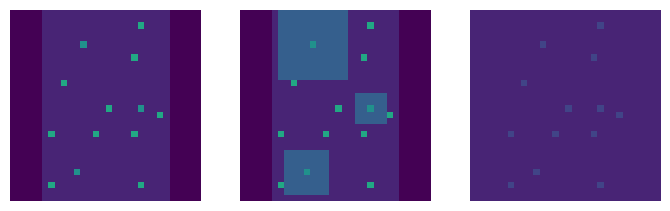

Validation: 100%|██████████| 9/9 [05:38<00:00, 37.62s/it]


Epoch 3/500, Loss: 1.8361831913415458, Accuracy: 49.19047860731868%
Epoch 4/500


Validation:  89%|████████▉ | 8/9 [05:21<00:38, 38.39s/it]

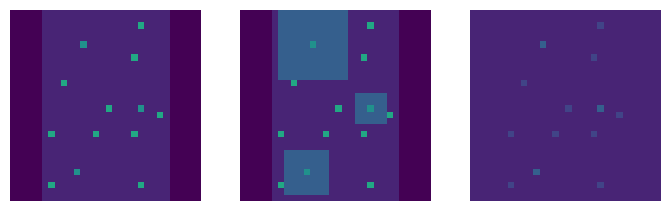

Validation: 100%|██████████| 9/9 [05:37<00:00, 37.51s/it]


Epoch 4/500, Loss: 1.7631116221016518, Accuracy: 51.38811348525605%
Epoch 5/500


Validation:  89%|████████▉ | 8/9 [05:18<00:37, 37.98s/it]

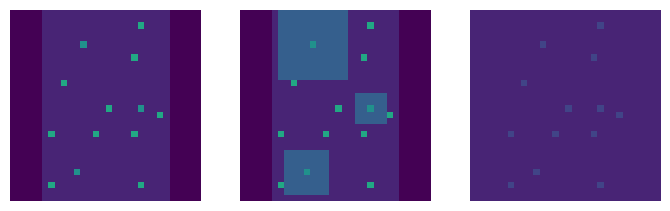

Validation: 100%|██████████| 9/9 [05:33<00:00, 37.09s/it]


Epoch 5/500, Loss: 1.7555394259799353, Accuracy: 50.119271176978124%
Epoch 6/500


Validation:  89%|████████▉ | 8/9 [06:18<00:44, 44.66s/it]

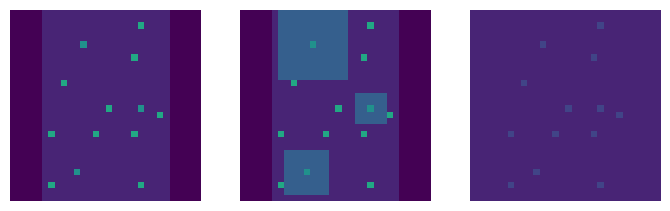

Validation: 100%|██████████| 9/9 [06:36<00:00, 44.03s/it]


Epoch 6/500, Loss: 1.8293389263685107, Accuracy: 48.69918286555347%
Epoch 7/500


Validation:  89%|████████▉ | 8/9 [05:47<00:38, 38.85s/it]

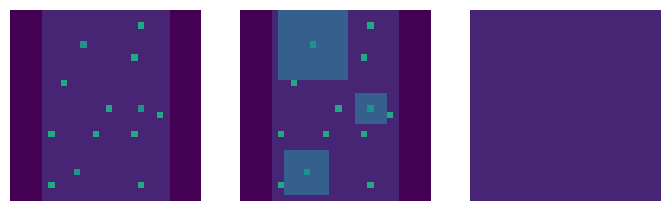

Validation: 100%|██████████| 9/9 [06:02<00:00, 40.22s/it]


Epoch 7/500, Loss: 1.777306171974305, Accuracy: 51.06024463279704%
Epoch 8/500


Validation:  89%|████████▉ | 8/9 [05:17<00:37, 37.98s/it]

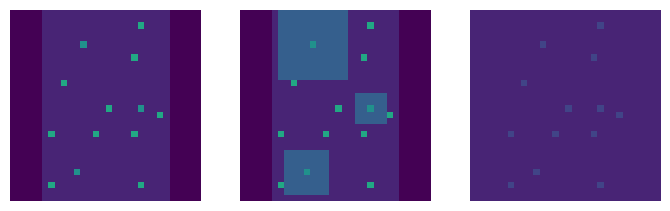

Validation: 100%|██████████| 9/9 [05:32<00:00, 36.96s/it]


Epoch 8/500, Loss: 1.8215880294759403, Accuracy: 49.19047860731868%
Epoch 9/500


Validation:  89%|████████▉ | 8/9 [04:46<00:34, 34.21s/it]

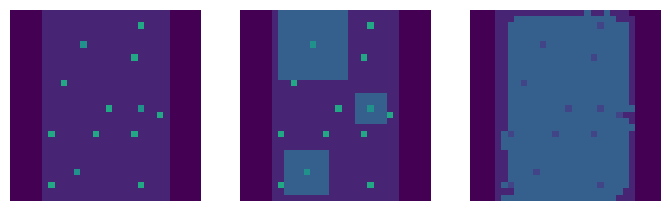

Validation: 100%|██████████| 9/9 [05:00<00:00, 33.35s/it]


Epoch 9/500, Loss: 1.8005709236661118, Accuracy: 49.849261533776584%
Epoch 10/500


Validation:  89%|████████▉ | 8/9 [05:21<00:38, 38.25s/it]

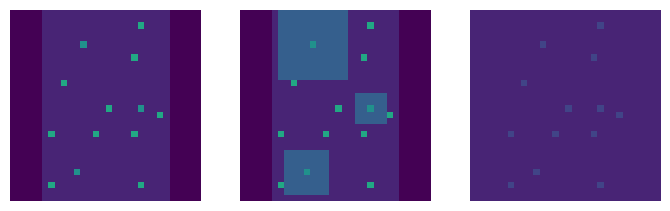

Validation: 100%|██████████| 9/9 [05:37<00:00, 37.47s/it]


Epoch 10/500, Loss: 1.8283144632501078, Accuracy: 48.8006902502157%
Epoch 11/500


Validation:  89%|████████▉ | 8/9 [05:32<00:39, 39.92s/it]

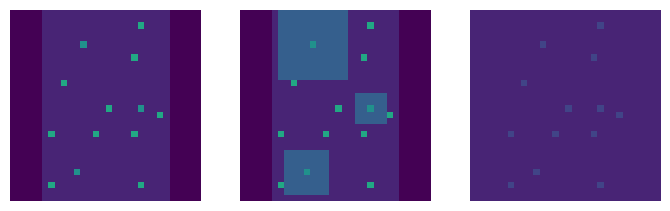

Validation: 100%|██████████| 9/9 [05:49<00:00, 38.80s/it]


Epoch 11/500, Loss: 1.819991776332935, Accuracy: 49.82692990915089%
Epoch 12/500


Validation:  89%|████████▉ | 8/9 [05:38<00:40, 40.28s/it]

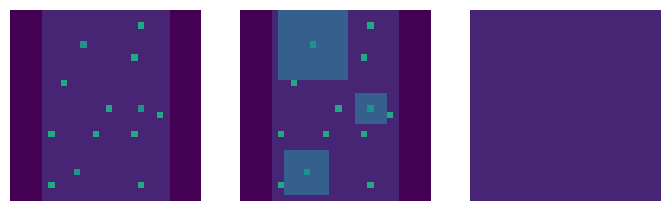

Validation: 100%|██████████| 9/9 [05:53<00:00, 39.29s/it]


Epoch 12/500, Loss: 1.8024539966002853, Accuracy: 49.7000456783231%
Epoch 13/500


Training:  44%|████▍     | 4/9 [02:08<02:30, 30.06s/it]

In [9]:
import torch
from torch.utils.data import DataLoader
from dataloader_sw import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc



train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 50,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 5,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
}


def criterion(y_pred, y):
    y = y.long().squeeze(1)
    # print(y_pred.shape, y.shape)
    weight = torch.ones(model_args['num_classes']).to(y.device)
    weight[0] = 0.05
    # weight[1] = 0.5
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f'Using {device} device')

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True, num_workers=8)

eval_dataset = ARC_Dataset(eval_challenge, eval_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False, num_workers=8)

# Outer Model 정의
outer_model = ARC_Net(**model_args).to(device)
outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Inner Loop 업데이트 함수
def inner_loop_update(model, example_input, example_output, inner_optimizer, criterion, steps):
    for _ in range(steps):
        model.train()
        prediction = model(example_input)
        
        loss = criterion(prediction, example_output)

        inner_optimizer.zero_grad()
        loss.backward()
        inner_optimizer.step()

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        
        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            # 모델의 가중치만 복사하여 이너 모델 초기화
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                              inner_optimizer, criterion, kwargs['example_data_num'])
            
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        meta_loss = torch.stack(task_losses).mean()
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()
        
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = []

    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        for task_number in range(input_tensor.shape[0]):
            inner_model = ARC_Net(**model_args).to(device)
            inner_model.load_state_dict(outer_model.state_dict())
            
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])
            inner_loop_update(inner_model, example_input[task_number], example_output[task_number],
                            inner_optimizer, criterion, kwargs['example_data_num'])

            with torch.no_grad():
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss.append(task_loss.item())

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()

                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

            del inner_model, inner_optimizer, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    mean_loss = sum(total_loss) / len(total_loss) if total_loss else 0
    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {mean_loss}, Accuracy: {accuracy}%')
    torch.cuda.empty_cache()


In [11]:
task_prediction.shape

torch.Size([1, 11, 30, 30])

In [12]:
prediction_class.shape
prediction_class

tensor([[[[1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 3, 3, 3],
          [1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3, 3, 3, 3, 3, 3],
          [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
           3, 3,